In [10]:
# this should look familiar from the previous labs. 
# We could choose any of the pre-built nets here instead. 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Nadam
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# This is a new built in dataset that we haven't seen before.
# It is 60,000 (50k training, 10k test) small (32x32) RGB images 
# classified into 100 classes:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Constant number of labels, square image shape
NUM_CLASSES = 100
IMAGE_SIZE = 96

# FOR DISPLAY PURPOSES
unprocessed_training_images = x_train
unprocessed_training_labels = y_train

# Because the network we're fine-tuning (MobileNetV2) has several pooling layers
# the smallest image it can process is 96x96, these images are 32x32. To fix this
# we are manually rescaling all the images using scipy. We are also applying the 
# MobileNetV2 preprocess_input function here. 
def adjust_input_image(rgb_data):
    adjusted = preprocess_input(rgb_data)
    
    # Scales width and height by 3, leaves color channels at original scale
    adjusted = ndimage.zoom(adjusted, (3, 3, 1), order=0)

    return adjusted

x_train = np.array([adjust_input_image(x) for x in x_train])
x_test = np.array([adjust_input_image(x) for x in x_test])

# And we still need to one-hot encode the labels as usual
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [2]:
# This should look familiar from previous labs.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

In [3]:
# The first way we'll do transfer learning REALLY saves time, but
# only works if you don't want to fine tune any of the layers 
# from the original network. What we can do instead is memorize
# the output of the base network, since it won't be changing,
# and then repeatedly train on those outputs and the training labels

# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Unlike before, we're going to just run the images through this base layer once
# This takes awhile, we're essentially doing a round of evaluation on both datasets.
# And we'll save them incase we want to experiment with different models to transfer
# on top of these.
training_features = base_model.predict(x_train)
np.savez('MobileNetV2_features_train', features=training_features)

test_features = base_model.predict(x_test)
np.savez('MobileNetV2_features_test', features=test_features)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 5s 133us/sample - loss: 3.2305 - accuracy: 0.2356 - val_loss: 2.2215 - val_accuracy: 0.4219
Epoch 2/10
40000/40000 [==============================] - 4s 105us/sample - loss: 2.2239 - accuracy: 0.4138 - val_loss: 1.9274 - val_accuracy: 0.4892
Epoch 3/10
40000/40000 [==============================] - 4s 110us/sample - loss: 1.9295 - accuracy: 0.4760 - val_loss: 1.7962 - val_accuracy: 0.5129
Epoch 4/10
40000/40000 [==============================] - 4s 109us/sample - loss: 1.7495 - accuracy: 0.5212 - val_loss: 1.7364 - val_accuracy: 0.5275
Epoch 5/10
40000/40000 [==============================] - 5s 114us/sample - loss: 1.6133 - accuracy: 0.5544 - val_loss: 1.6813 - val_accuracy: 0.5384
Epoch 6/10
40000/40000 [==============================] - 4s 108us/sample - loss: 1.4842 - accuracy: 0.5821 - val_loss: 1.6554 - val_accuracy: 0.5460
Epoch 7/10
40000/40000 [==========================

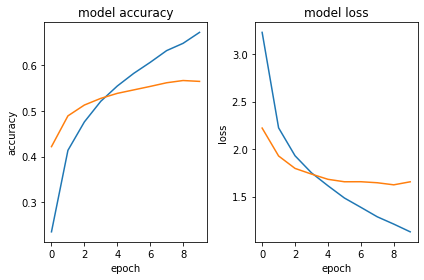

Test loss: 1.64
Test accuracy: 0.568


In [20]:
# If you have not run the above cell during this session, uncomment these lines to load the features.
# training_features = np.load('MobileNetV2_features_train.npz')['features']
# test_features = np.load('MobileNetV2_features_test.npz')['features']

# Also unlike before, we're going to build a complete model
# in the normal way, but define the input shape based on the 
# features predicted by base_model!
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=training_features.shape[1:]))

# Note from the summary, this will result in 1280 nodes, let's use the classic "squeeze" and add dropout
model.add(Dense(units=640, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=320, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=160, activation='relu'))
model.add(Dropout(rate=0.1))

#model.add(Dense(units=160, activation='relu'))
#model.add(Dropout(rate=0.1))
#model.add(Dense(units=320, activation='relu'))
#model.add(Dropout(rate=0.2))
#model.add(Dense(units=640, activation='relu'))
#model.add(Dropout(rate=0.3))
#model.add(Dense(units=1280, activation='relu'))
#model.add(Dropout(rate=0.4))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Nadam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit(training_features, y_train, batch_size=128, epochs=10, validation_split=0.2, verbose=True)
#history, model = transfer_from_mobilenet(SGD(learning_rate=0.001), 0, 128, 5)
plot_training_history(history, model)
loss, accuracy = model.evaluate(test_features, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')